In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install shap
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00


Acurácia do Random Forest: 0.9173
Acurácia do SVM: 0.9882


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Acurácia do Logistic Regression: 1.0000
Acurácia do K-Nearest Neighbors: 0.8836
Acurácia do Naive Bayes: 0.8741
Acurácia do XGBoost: 0.9465
Acurácia do Decision Tree: 0.7891


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Acurácia do AdaBoost: 0.7384
Acurácia do CatBoost: 0.9866


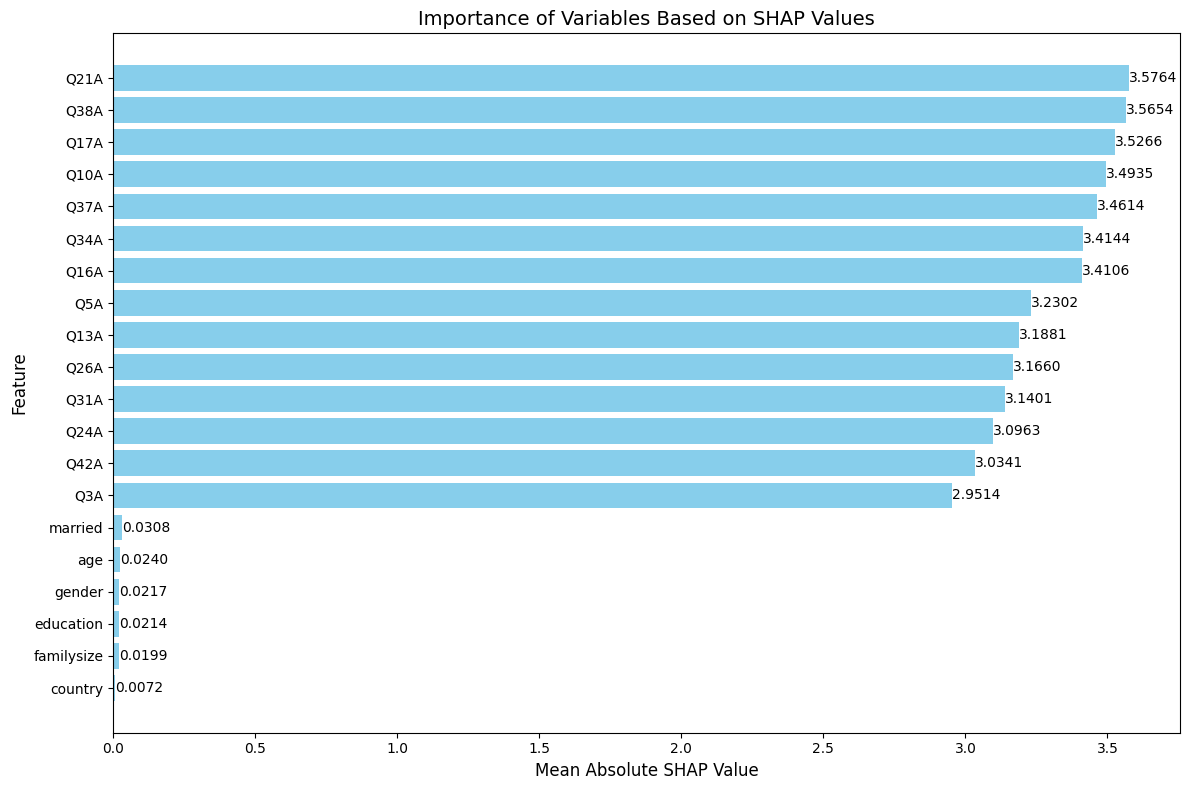

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from google.colab import files
import numpy as np
import shap
import matplotlib.pyplot as plt
import json

# Função para prever índice de depressão e calcular métricas
def prever_indice_depressao(data):
    X = data.drop(columns=['soma_depressao', 'indice_depressao'])
    y = data['indice_depressao']

    # Imputar valores faltantes
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # Dividir os dados
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Normalizar os dados
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    # Dicionário de modelos
    modelos = {
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(),
        'Logistic Regression': LogisticRegression(multi_class='multinomial', max_iter=1000),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB(),
        'XGBoost': XGBClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0),
    }

    # Dicionário para armazenar os modelos treinados e suas acurácias
    modelos_treinados = {}

    for nome, modelo in modelos.items():
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        modelos_treinados[nome] = {'modelo': modelo, 'accuracy': accuracy}
        print(f"Acurácia do {nome}: {accuracy:.4f}")  # Imprimir a acurácia de cada modelo

    # Salvar os modelos treinados e suas acurácias
    joblib.dump(modelos_treinados, 'modelos_treinados.pkl')

    return modelos_treinados, X_train_scaled, X_test_scaled, y_train, y_test

# Função para calcular a importância das variáveis com SHAP
def calcular_shap_importance_logistic_regression(X_train_scaled, X_test_scaled, modelo):
    # Inicializar o explicador SHAP apropriado para modelos lineares
    explainer = shap.Explainer(modelo, X_train_scaled)

    # Calcular os valores SHAP
    shap_values = explainer(X_test_scaled)

    # Salvar a matriz completa de valores SHAP
    shap_values_df = pd.DataFrame(shap_values.values.reshape(-1, shap_values.values.shape[1]), columns=X_test_scaled.columns)
    shap_values_df.to_csv('/content/drive/My Drive/ComparativoAMDepressao/shap_values_matrix.csv', index=False)

    # Calcular a importância média das variáveis
    shap_importance = np.mean(np.abs(shap_values.values), axis=(0, 2))  # Média sobre as amostras e classes

    # Criar um DataFrame para armazenar os valores SHAP médios
    shap_importance_df = pd.DataFrame({
        'Feature': X_test_scaled.columns,
        'Mean Absolute SHAP Value': shap_importance
    })

    # Ordenar por importância
    shap_importance_df = shap_importance_df.sort_values(by='Mean Absolute SHAP Value', ascending=False)

    # Informações do gráfico a serem salvas
    grafico_info = {
        "features": shap_importance_df['Feature'].tolist(),
        "mean_abs_shap_values": shap_importance_df['Mean Absolute SHAP Value'].tolist(),
        "color": "skyblue",
        "figsize": (12, 8),
        "xlabel": "Mean Absolute SHAP Value",
        "ylabel": "Feature",
        "title": "Importância das Variáveis com Base nos Valores SHAP",
        "save_path": '/content/drive/My Drive/ComparativoAMDepressao/shap_importance_plot.png'
    }

    # Salvar as informações do gráfico em um arquivo JSON
    with open('/content/drive/My Drive/ComparativoAMDepressao/grafico_info.json', 'w') as f:
        json.dump(grafico_info, f)

    # Plotar o gráfico de importância
    plt.figure(figsize=(12, 8))
    plt.barh(shap_importance_df['Feature'], shap_importance_df['Mean Absolute SHAP Value'], color='skyblue')
    plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Importance of Variables Based on SHAP Values', fontsize=14)
    plt.gca().invert_yaxis()  # Inverter o eixo y para mostrar as variáveis mais importantes no topo
    plt.tight_layout()

    # Adicionar rótulos nos valores para cada barra
    for index, value in enumerate(shap_importance_df['Mean Absolute SHAP Value']):
        plt.text(value, index, f'{value:.4f}', va='center')

    # Salvar o gráfico como imagem
    plt.savefig(grafico_info['save_path'])

    # Mostrar o gráfico
    plt.show()

# Carregar os dados
file_path = '/content/drive/My Drive/calc/dataset.csv'
data = pd.read_csv(file_path)

# Treinar e salvar os modelos
modelos_treinados, X_train_scaled, X_test_scaled, y_train, y_test = prever_indice_depressao(data)

# Calcular e plotar a importância das variáveis usando SHAP para o modelo de Regressão Logística
calcular_shap_importance_logistic_regression(X_train_scaled, X_test_scaled, modelos_treinados['Logistic Regression']['modelo'])

# Fazer o download dos arquivos de modelos e JSON
files.download('modelos_treinados.pkl')
files.download('/content/drive/My Drive/ComparativoAMDepressao/grafico_info.json')
